# Mira regnet

In [5]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import torch

import pyciemss
from pyciemss.PetriNetODE.interfaces import (setup_petri_model, reset_model, intervene_petri_model, intervene,
                                             sample_petri, calibrate_petri, optimize, load_petri_model)
from pyciemss.PetriNetODE.models import MiraRegNetODESystem, LotkaVolterra
import mira
from pyciemss.utils import get_tspan

import warnings
warnings.filterwarnings('ignore')


## Plotting utils

In [1]:
def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population')
    return ax

def plot_trajectory(data, tspan, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ax.plot(tspan, data.squeeze().detach().numpy(), color, alpha=alpha, lw=lw, marker=marker, label=label)
    
    return ax

COLORS=['red','blue','green','black','gold', 'magenta', 'purple']

def plot_trajectories(sol, tspan, data=None):
    fig = plt.figure(facecolor='w', figsize=(6, 6))
    ax = fig.add_subplot(111, axisbelow=True) # setup graph
    d_keys = [list(x[1].keys())[0] for x in data] if data else [] # get affected variables
    torch_tspan = torch.as_tensor(tspan) # for use in multi-trajectory graph
    indices = torch.ones_like(tspan).bool()
    
    for i,var in enumerate([s for s in sol if '_sol' in s]): # skip beta, gamma parameters
        
        if len(sol[var]) == 1: # single trajectory, draw line
            ax.plot(tspan, sol[var].squeeze().detach().numpy(), COLORS[i], alpha=0.5, lw=3, label=var[:-4])
        
        else: # fill between multiple trajectories
            I_low = torch.quantile(sol[var], 0.05, dim=0).detach().numpy()
            I_up  = torch.quantile(sol[var], 0.95, dim=0).detach().numpy()
            ax.fill_between(torch_tspan, I_low, I_up,
                            alpha=0.2, color=COLORS[i], label=var[:-4])
        
        if var[:-4] in d_keys: # plot training points of this variable
            x = np.array([x[0] for x in data if var[:-4] in list(x[1].keys())])
            y = np.array([x[1][var[:-4]] for x in data if var[:-4] in list(x[1].keys())]) # without '_sol' suffix
            ax.scatter(x,y,label=var[:-4]+" data",color=COLORS[i])
    
    ax.legend()
    return ax
    
def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='--', label=f'intervention at T={t}')

    return ax


## Petri utils

In [2]:
from pyciemss.interfaces import DynamicalSystem
def reparameterize(model: DynamicalSystem, parameters: dict) -> DynamicalSystem:
    """Intervenes on an initialized model to set the parameters as specified in the dictionary."""
    parameter_interventions = [ ((i+1)*1e-5, param, value) for i, (param, value) in enumerate(parameters.items())]
    return intervene(model, parameter_interventions)


# Lotka Volterra

### Load model

In [3]:
from pyciemss.PetriNetODE.models import MiraRegNetODESystem
from pyciemss.PetriNetODE.base import get_name
import os
ASKENET_PATH = "../../test/models/may-hackathon"
filename = "lotka_volterra.json"
filename = os.path.join(ASKENET_PATH, filename)

raw_deterministic_lotka_volterra = MiraRegNetODESystem.from_askenet_regnet(filename)


In [6]:
tspan = get_tspan(1, 50, 500)
def read_variables(variables):
    if variables is None:
        return ""
    else:
        return ",".join([v.data['name'] for v in variables if hasattr(v, 'data') and 'name' in v.data and v.data['name']])
def read_parameters(param):
    return param.value

### Sample trajectories from prior distribution

<Axes: >

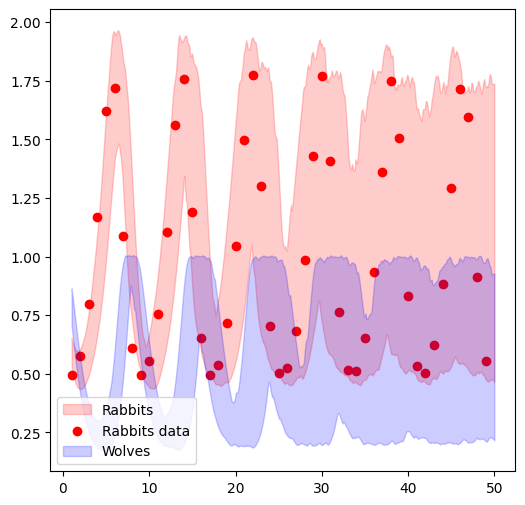

In [55]:
raw_lotka_volterra = MiraRegNetODESystem.from_askenet_regnet(filename)
uncertain_lotka_volterra = setup_petri_model(
    raw_lotka_volterra, start_time=0.0, start_state=dict(
        Rabbits=1.0, Wolves=1.0))
prior_samples = sample_petri(uncertain_lotka_volterra, tspan, 50)
plot_trajectories(prior_samples, tspan, data=data)

## Calibrate uncertain Lotka Volterra

We make one observation per day. Because we simulate 500 data points over 50 days, we need to sample every 10th timepoint.

### Sample trajectory

<Axes: >

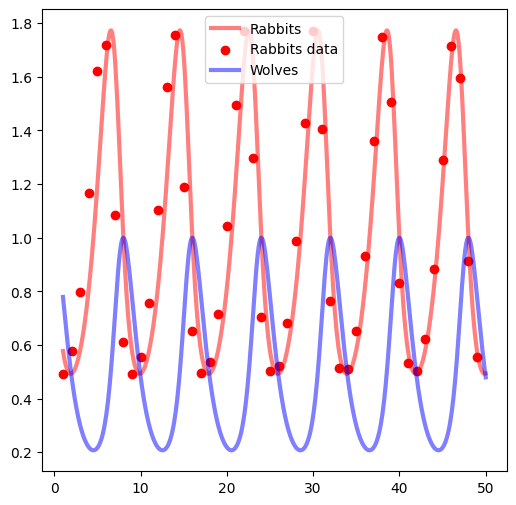

In [45]:
observed_lotka_volterra = reparameterize(
    uncertain_lotka_volterra,
    dict(alpha=0.67,beta=1.33,gamma=1.0, delta = 1.0))
observed_trajectory = sample_petri(deterministic_lotka_volterra, tspan, 1)
data =[(i, dict(Rabbits=observed_trajectory['Rabbits_sol'][0][i*10]))
            for i in range(1,50)]
plot_trajectories(observed_trajectory, tspan, data)

trajectory = sample_petri(deterministic_lotka_volterra, tspan, 1)
data =[(i, dict(Rabbits=trajectory['Rabbits_sol'][0][i*10]))
            for i in range(1,50)]
fitted_parameters = calibrate_petri(uncertain_lotka_volterra, data = data )
posterior_samples = sample_petri(uncertain_lotka_volterra, 
                                 timepoints=tspan, num_samples=50, 
                           inferred_parameters=fitted_parameters)
plot_trajectories(dict(
        Rabbits_prior_sol= prior_samples['Rabbits_sol'], 
        Wolves_prior_sol= prior_samples['Wolves_sol'],
        Rabbits_posterior_sol= posterior_samples['Rabbits_sol'],
        Wolves_posterior_sol= posterior_samples['Wolves_sol'],
        Rabbits_data_sol=trajectory['Rabbits_sol'],
    ),    
    tspan, data=data)

In [41]:
import numpy as np
var = 'Rabbits_sol'
x = np.array([x[0] for x in data if var[:-4] in list(x[1].keys())])
x
y = np.array([x[1][var[:-4]] for x in data if var[:-4] in list(x[1].keys())]) # without '_sol' suffix
y

array([0.49311334, 0.5761071 , 0.79696745, 1.1683195 , 1.622145  ,
       1.7182871 , 1.0860115 , 0.61133426, 0.49304482, 0.55553335,
       0.7555379 , 1.105035  , 1.5612775 , 1.7557393 , 1.1907388 ,
       0.6529035 , 0.49655807, 0.53780633, 0.7173547 , 1.0445422 ,
       1.4959726 , 1.7724904 , 1.2989472 , 0.70307297, 0.50397617,
       0.52292436, 0.6823503 , 0.9871094 , 1.4281499 , 1.7697171 ,
       1.4061519 , 0.7627092 , 0.5157064 , 0.51091284, 0.6504514 ,
       0.932902  , 1.3593626 , 1.7495863 , 1.507194  , 0.8324828 ,
       0.53224903, 0.5018276 , 0.6215848 , 0.8820089 , 1.2908485 ,
       1.7148274 , 1.5968877 , 0.9126851 , 0.5542082 ], dtype=float32)

### Sample trajectories from interventional distribution
At $t=25$ we intervene on the prior parameters to set $\alpha=1.5$.

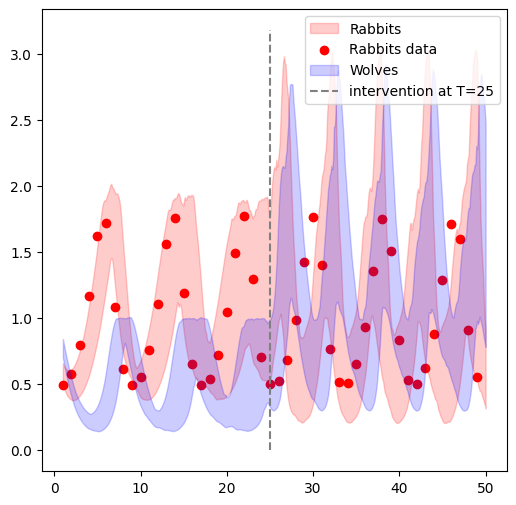

In [48]:
intervened_lotka_volterra = intervene_petri_model(
    uncertain_lotka_volterra, [(25, 'alpha', 1.5)])
intervened_samples = sample_petri(
    intervened_lotka_volterra, timepoints=tspan, num_samples = 50)
ax = plot_trajectories(intervened_samples, tspan, data)
ax = plot_intervention_line(25, ax=ax)
ax.legend()

### Sample trajectories from counterfactual distribution
At $t=25$ here we intervene on the calibrated parameters to set $\alpha=1.5$

In [50]:
observed_lotka_volterra = reparameterize(
    uncertain_lotka_volterra,
    dict(alpha=0.67,beta=1.33,gamma=1.0, delta = 1.0))
observed_trajectory = sample_petri(deterministic_lotka_volterra, tspan, 1)
data =[(i, dict(Rabbits=observed_trajectory['Rabbits_sol'][0][i*10]))
            for i in range(1,50)]
calibrated_parameters = calibrate_petri(
    uncertain_lotka_volterra, data = data)
counterfactual_samples = sample_petri(
    intervened_lotka_volterra, timepoints=tspan, num_samples = 50,
    inferred_parameters=calibrated_parameters)

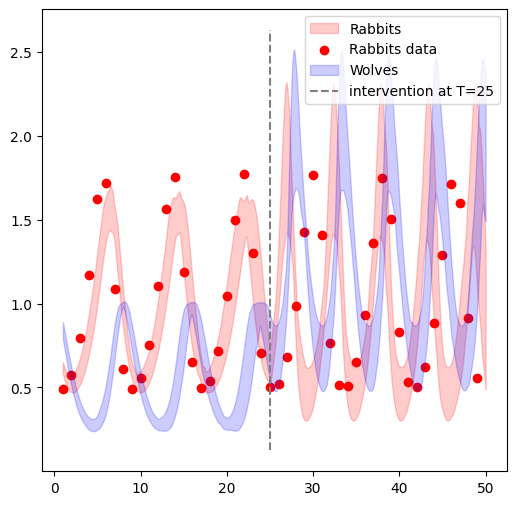

In [51]:
ax= plot_trajectories(counterfactual_samples, tspan, data=data)
ax = plot_intervention_line(25, ax)
ax.legend()

In [38]:
data

[(1, {'Rabbits': tensor(0.4931)}),
 (2, {'Rabbits': tensor(0.5761)}),
 (3, {'Rabbits': tensor(0.7970)}),
 (4, {'Rabbits': tensor(1.1683)}),
 (5, {'Rabbits': tensor(1.6221)}),
 (6, {'Rabbits': tensor(1.7183)}),
 (7, {'Rabbits': tensor(1.0860)}),
 (8, {'Rabbits': tensor(0.6113)}),
 (9, {'Rabbits': tensor(0.4930)}),
 (10, {'Rabbits': tensor(0.5555)}),
 (11, {'Rabbits': tensor(0.7555)}),
 (12, {'Rabbits': tensor(1.1050)}),
 (13, {'Rabbits': tensor(1.5613)}),
 (14, {'Rabbits': tensor(1.7557)}),
 (15, {'Rabbits': tensor(1.1907)}),
 (16, {'Rabbits': tensor(0.6529)}),
 (17, {'Rabbits': tensor(0.4966)}),
 (18, {'Rabbits': tensor(0.5378)}),
 (19, {'Rabbits': tensor(0.7174)}),
 (20, {'Rabbits': tensor(1.0445)}),
 (21, {'Rabbits': tensor(1.4960)}),
 (22, {'Rabbits': tensor(1.7725)}),
 (23, {'Rabbits': tensor(1.2989)}),
 (24, {'Rabbits': tensor(0.7031)}),
 (25, {'Rabbits': tensor(0.5040)}),
 (26, {'Rabbits': tensor(0.5229)}),
 (27, {'Rabbits': tensor(0.6824)}),
 (28, {'Rabbits': tensor(0.9871)}),
 

In [37]:
d_keys = [list(x[1].keys())[0] for x in data] if data else [] # get affected variables
d_keys

['Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits',
 'Rabbits']

In [34]:
observed_trajectory

{'alpha': tensor([0.7116]),
 'gamma': tensor([1.0427]),
 'beta': tensor([1.2765]),
 'delta': tensor([0.9803]),
 'Rabbits_sol': tensor([[0.5775, 0.5582, 0.5420, 0.5284, 0.5172, 0.5084, 0.5016, 0.4968, 0.4939,
          0.4927, 0.4931, 0.4951, 0.4986, 0.5035, 0.5098, 0.5175, 0.5266, 0.5369,
          0.5487, 0.5617, 0.5761, 0.5918, 0.6089, 0.6274, 0.6473, 0.6685, 0.6912,
          0.7154, 0.7411, 0.7683, 0.7970, 0.8272, 0.8590, 0.8924, 0.9274, 0.9639,
          1.0019, 1.0414, 1.0824, 1.1247, 1.1683, 1.2130, 1.2587, 1.3052, 1.3521,
          1.3992, 1.4461, 1.4924, 1.5376, 1.5811, 1.6221, 1.6601, 1.6941, 1.7232,
          1.7465, 1.7632, 1.7722, 1.7728, 1.7643, 1.7462, 1.7183, 1.6808, 1.6341,
          1.5792, 1.5173, 1.4498, 1.3784, 1.3047, 1.2304, 1.1571, 1.0860, 1.0182,
          0.9543, 0.8950, 0.8405, 0.7909, 0.7461, 0.7060, 0.6703, 0.6389, 0.6113,
          0.5874, 0.5667, 0.5491, 0.5343, 0.5221, 0.5122, 0.5045, 0.4988, 0.4950,
          0.4930, 0.4927, 0.4940, 0.4968, 0.5010, 0.50